# Experiments


## Notes

* Prerequisites
    * `pip3 install torch == 1.2.0`
    * `pip3 install gym == 0.23.1`
    * `pip3 install mujoco == 2.2.1`
* For lunar lander    
    * `conda install swig`
    * `pip3 install box2d-py`
* if there's a`mujoco_py does not exist` error, on the `gym` and/or `d4rl` package, import `mujoco as mujoco_py`
    * ~/anaconda3/envs/plas/lib/python3.7/site-packages/gym/envs/mujoco/mujoco_env.py
    * ~/anaconda3/envs/plas/lib/python3.7/site-packages/gym/envs/mujoco/pusher.py


* Pybullet datasets reference
    * https://github.com/takuseno/d4rl-pybullet
    * https://github.com/Farama-Foundation/D4RL/tree/f2a05c0d66722499bf8031b094d9af3aea7c372b
    
* PLAS algorithm
    * https://github.com/Wenxuan-Zhou/PLAS
* Gym documentation
    * https://www.gymlibrary.dev/environments/mujoco/walker2d/

In [1]:
env_name = "LunarLander-v2"

## Packages

In [2]:
import gym
gym

<module 'gym' from '/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/gym/__init__.py'>

In [3]:
"""
Based on https://github.com/sfujim/BCQ
"""
import argparse
import numpy as np
import os
import pickle
import utils
import algos
from logger import logger, setup_logger
# import d4rl
import torch
import time
from eval_functions import eval_critic
import shutil
import matplotlib.pyplot as plt
from copy import deepcopy
import pandas as pd

/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No module named 'mujoco_py'
No module named 'flow'
No module named 'carla'


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# force cpu
# device = torch.device("cpu")
print(device)
torch.cuda.get_device_name(0)

cuda


/home/prince/anaconda3/envs/plas/lib/python3.7/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA GeForce RTX 3070 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA GeForce RTX 3070 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


'NVIDIA GeForce RTX 3070'

## Gym Environments

In [5]:
# print(gym.envs.registry.all())

## Inputs

In [6]:
# %tb

# parser = argparse.ArgumentParser()

# # Additional parameters
# parser.add_argument("--ExpID", default=1, type=int)              # Experiment ID
# parser.add_argument('--log_dir', default='./results/', type=str)    # Logging directory
# parser.add_argument("--load_model", default=None, type=str)         # Load model and optimizer parameters
# parser.add_argument("--save_model", default=True, type=bool)        # Save model and optimizer parameters
# parser.add_argument("--save_freq", default=1e5, type=int)           # How often it saves the model
# #parser.add_argument("--env_name", default="walker2d-medium-v0")     # OpenAI gym environment name
# parser.add_argument("--env_name", default='bullet-walker2d-medium-v0')     # OpenAI gym environment name
# parser.add_argument("--algo_name", default="Latent")                # Algorithm: Latent or LatentPerturbation.
# parser.add_argument("--dataset", default=None, type=str)            # path to dataset if not d4rl env
# parser.add_argument("--seed", default=0, type=int)                  # Sets Gym, PyTorch and Numpy seeds
# parser.add_argument("--eval_freq", default=1e3, type=int)           # How often (time steps) we evaluate
# parser.add_argument("--max_timesteps", default=5e5, type=int)       # Max time steps to run environment for
# parser.add_argument('--vae_mode', default='train', type=str)		# VAE mode: train or load from a specific version
# parser.add_argument('--vae_lr', default=1e-4, type=float)		    # vae training iterations
# parser.add_argument('--vae_itr', default=500000, type=int)		    # vae training iterations
# parser.add_argument('--vae_hidden_size', default=750, type=int)		# vae training iterations
# parser.add_argument('--max_latent_action', default=2., type=float)  # max action of the latent policy
# parser.add_argument('--phi', default=0., type=float)	            # max perturbation
# parser.add_argument('--batch_size', default=100, type=int)	        # batch size
# parser.add_argument('--actor_lr', default=1e-4, type=float)	        # policy learning rate
# parser.add_argument('--critic_lr', default=1e-3, type=float)	    # policy learning rate
# parser.add_argument('--tau', default=0.005, type=float)	            # actor network size

# # args = parser.parse_args()
# args = parser.parse_args("")

In [7]:
%tb

div = 10

parser = argparse.ArgumentParser()

# Additional parameters
parser.add_argument("--ExpID", default=2, type=int)                      # Experiment ID
parser.add_argument('--log_dir', default='./results/', type=str)         # Logging directory
parser.add_argument("--load_model", default=None, type=str)              # Load model and optimizer parameters
parser.add_argument("--save_model", default=True, type=bool)             # Save model and optimizer parameters
parser.add_argument("--save_freq", default=1e3//div, type=int)           # How often it saves the model
parser.add_argument("--env_name", default=env_name)   # OpenAI gym environment name
parser.add_argument("--algo_name", default="Latent")                     # Algorithm: Latent or LatentPerturbation.
parser.add_argument("--dataset", default=None, type=str)                 # path to dataset if not d4rl env
parser.add_argument("--seed", default=0, type=int)                       # Sets Gym, PyTorch and Numpy seeds
parser.add_argument("--eval_freq", default=1e3//div, type=int)           # How often (time steps) we evaluate
parser.add_argument("--max_timesteps", default=5e3, type=int)            # Max time steps to run environment for
parser.add_argument('--vae_mode', default='train', type=str)		     # VAE mode: train or load from a specific version
parser.add_argument('--vae_lr', default=1e-4, type=float)                # vae training iterations
parser.add_argument('--vae_itr', default=500000//div, type=int)		     # vae training iterations
parser.add_argument('--vae_hidden_size', default=128, type=int)		     # vae training iterations
parser.add_argument('--max_latent_action', default=2., type=float)       # max action of the latent policy
parser.add_argument('--phi', default=0., type=float)	                 # max perturbation
parser.add_argument('--batch_size', default=100, type=int)	             # batch size
parser.add_argument('--actor_lr', default=1e-4, type=float)	             # policy learning rate
parser.add_argument('--critic_lr', default=1e-3, type=float)	         # policy learning rate
parser.add_argument('--tau', default=0.005, type=float)	                 # actor network size

# args = parser.parse_args()
args = parser.parse_args("")

No traceback available to show.


## Setup

### Folders, Logging

In [8]:
# # delete results
# if os.path.isdir('./results'):
#     shutil.rmtree('./results/')

In [26]:
if args.dataset is None:
    args.dataset = args.env_name

# Setup Logging
file_name = f"Exp{args.ExpID:04d}_{args.algo_name}_{args.dataset}-{args.seed}"
folder_name = os.path.join(args.log_dir, file_name)
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
print(folder_name)
if os.path.exists(os.path.join(folder_name, 'variant.json')):
    shutil.rmtree(folder_name)
variant = vars(args)
variant.update(node=os.uname()[1])
setup_logger(os.path.basename(folder_name), variant=variant, log_dir=folder_name)

./results/Exp0002_Latent_LunarLanderContinuous-v2-0
2022-09-05 20:45:52.773058 PST | [Exp0002_Latent_LunarLanderContinuous-v2-0] [Exp0002_Latent_LunarLanderContinuous-v2-0] Variant:
2022-09-05 20:45:52.775328 PST | [Exp0002_Latent_LunarLanderContinuous-v2-0] [Exp0002_Latent_LunarLanderContinuous-v2-0] {
  "ExpID": 2,
  "log_dir": "./results/",
  "load_model": null,
  "save_model": true,
  "save_freq": 100.0,
  "env_name": "LunarLanderContinuous-v2",
  "algo_name": "Latent",
  "dataset": "LunarLanderContinuous-v2",
  "seed": 0,
  "eval_freq": 100.0,
  "max_timesteps": 5000.0,
  "vae_mode": "train",
  "vae_lr": 0.0001,
  "vae_itr": 50000,
  "vae_hidden_size": 128,
  "max_latent_action": 2.0,
  "phi": 0.0,
  "batch_size": 100,
  "actor_lr": 0.0001,
  "critic_lr": 0.001,
  "tau": 0.005,
  "node": "computer"
}


'./results/Exp0002_Latent_LunarLanderContinuous-v2-0'

### Environment

In [10]:
# Setup Environment
env = gym.make(args.env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

# Set seeds
env.seed(args.seed)
env.action_space.seed(args.seed)
torch.manual_seed(args.seed)
np.random.seed(args.seed)

# check
print(env)
print(state_dim)
print(action_dim)
print(max_action)

<TimeLimit<LunarLanderContinuous<LunarLanderContinuous-v2>>>
8
2
1.0


## Load Dataset

In [11]:
import joblib
dataset = joblib.load('lunar_lander_data_1.joblib')

In [12]:
# # Load Dataset
# if args.env_name == args.dataset:
#     dataset = d4rl.qlearning_dataset(env)  # Load d4rl dataset
# else:
#     if args.dataset == 'hopper-medium-expert':
#         dataset1 = d4rl.qlearning_dataset(gym.make('hopper-medium-v0'))
#         dataset2 = d4rl.qlearning_dataset(gym.make('hopper-expert-v0'))
#         dataset = {key:np.concatenate([dataset1[key], dataset2[key]]) for key in dataset1.keys()}
#         print("Loaded data from hopper-medium-v0 and hopper-expert-v0")
#     else:
#         dataset_file = os.path.dirname(os.path.abspath(__file__)) + '/dataset/'+args.dataset + '.pkl'
#         dataset = pickle.load(open(dataset_file,'rb'))
#         print("Loaded data from "+dataset_file)

In [13]:
type(dataset)

dict

In [14]:
print(dataset['observations'].shape)
print(dataset['actions'].shape)
print(dataset['rewards'].shape)
print(dataset['terminals'].shape)

(100, 8)
(100, 2)
(100,)
(100,)


In [15]:
dataset

{'observations': array([[-0.00634413,  1.4186145 , -0.64261615,  0.34195057,  0.00735813,
          0.14556213,  0.        ,  0.        ],
        [-0.01268883,  1.425731  , -0.6417467 ,  0.31624138,  0.01455105,
          0.14387177,  0.        ,  0.        ],
        [-0.01903381,  1.4322493 , -0.6417694 ,  0.28961113,  0.02173963,
          0.14378524,  0.        ,  0.        ],
        [-0.02537909,  1.438168  , -0.64179057,  0.26293674,  0.02892731,
          0.14376694,  0.        ,  0.        ],
        [-0.03172455,  1.4434875 , -0.6418116 ,  0.23626433,  0.03611385,
          0.14374404,  0.        ,  0.        ],
        [-0.0380702 ,  1.4482076 , -0.64183277,  0.20959234,  0.04329922,
          0.1437208 ,  0.        ,  0.        ],
        [-0.04441614,  1.4523284 , -0.6418538 ,  0.1829203 ,  0.05048345,
          0.14369804,  0.        ,  0.        ],
        [-0.05076227,  1.45585   , -0.64187473,  0.15624808,  0.05766653,
          0.1436751 ,  0.        ,  0.        ],


In [16]:
dataset['terminals']

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False])

In [17]:
pd.DataFrame(dataset['observations'])

,0,1,2,3,4,5,6,7
0,-0.006344,1.418615,-0.642616,0.341951,0.007358,0.145562,0.0,0.0
1,-0.012689,1.425731,-0.641747,0.316241,0.014551,0.143872,0.0,0.0
2,-0.019034,1.432249,-0.641769,0.289611,0.021740,0.143785,0.0,0.0
3,-0.025379,1.438168,-0.641791,0.262937,0.028927,0.143767,0.0,0.0
4,-0.031725,1.443488,-0.641812,0.236264,0.036114,0.143744,0.0,0.0
...,...,...,...,...,...,...,...,...
95,-0.957629,0.940342,-1.848298,-0.580135,0.874577,0.207723,0.0,0.0
96,-0.976400,0.927173,-1.883736,-0.590595,0.884766,0.203775,0.0,0.0
97,-0.995484,0.913961,-1.915190,-0.592731,0.895370,0.212067,0.0,0.0
98,-0.006701,1.407479,-0.678711,-0.152982,0.007771,0.153738,0.0,0.0


In [18]:
pd.DataFrame(dataset['actions'])

,0,1
0,-0.051508,0.091953
1,-0.048553,0.091511
2,-0.045547,0.091156
3,-0.042530,0.090787
4,-0.039505,0.090402
...,...,...
95,0.033970,0.136491
96,0.034355,0.136887
97,0.033800,0.137920
98,0.001501,0.079570


In [19]:
pd.DataFrame(dataset['rewards'])

,0
0,-0.185435
1,-0.243159
2,-0.267788
3,-0.298418
4,-0.332742
...,...
95,-5.303900
96,-4.775392
97,-100.000000
98,-0.524435


In [20]:
pd.DataFrame(dataset['terminals'])

,0
0,False
1,False
2,False
3,False
4,False
...,...
95,False
96,False
97,True
98,False


## Train

In [21]:
latent_dim = action_dim * 2
state_dim, action_dim, latent_dim, max_action, args.vae_lr, args.vae_hidden_size

(8, 2, 4, 1.0, 0.0001, 128)

In [22]:
# Define VAE
vae_trainer = algos.VAEModule(state_dim, action_dim, latent_dim, max_action, vae_lr=args.vae_lr, hidden_size=args.vae_hidden_size)

In [27]:
# Train or Load VAE
if args.vae_mode == 'train':
    # Train VAE
    print(time.ctime(), "Training VAE...")
    logs = vae_trainer.train(dataset, folder_name, iterations=args.vae_itr)
else:
    # Select vae automatically
    vae_dirname = os.path.dirname(os.path.abspath(__file__)) + '/models/vae_' + args.vae_mode
    vae_filename = args.dataset + '-' + str(args.seed)
    vae_trainer.load(vae_filename, vae_dirname)
    print('Loaded VAE from:' + os.path.join(vae_dirname, vae_filename))

Mon Sep  5 20:45:57 2022 Training VAE...
Itr 50000 Training loss:3.109e-08


In [28]:
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)
replay_buffer.load(dataset)

policy = None
if args.algo_name == 'Latent':
    policy = algos.Latent(vae_trainer.vae, state_dim, action_dim, latent_dim, max_action,**vars(args))
elif args.algo_name == 'LatentPerturbation':
    policy = algos.LatentPerturbation(vae_trainer.vae, state_dim, action_dim, latent_dim, max_action,**vars(args))

Dataset size:99


In [29]:
# Runs policy for X episodes and returns average reward
# A fixed seed is used for the eval environment
def eval_policy(policy, env, eval_episodes=30, random=False):
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = env.reset(), False
        while not done:
            if random:
                action = env.action_space.sample()
            else:
                action = policy.select_action(np.array(state))
            state, reward, done, _ = env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes

    info = {'AverageReturn': avg_reward}
    print ("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print ("---------------------------------------")
    return info

In [38]:
episode_num = 0
done = True
training_iters = 0
evaluations = []
best_perf = -np.inf
best_policy = None

while training_iters < args.max_timesteps:
    # Train
    pol_vals = policy.train(replay_buffer, iterations=int(args.eval_freq), batch_size=args.batch_size)
    training_iters += args.eval_freq
    print("Training iterations: " + str(training_iters))
    logger.record_tabular('Training Epochs', int(training_iters // int(args.eval_freq)))  
    
    # Save BEST Model
    if training_iters % args.save_freq == 0 and args.save_model:
        
        # evaluate policy
        info = eval_policy(policy, env)       
        
        if info['AverageReturn'] > best_perf:
            best_perf = info['AverageReturn']
            best_policy = deepcopy(policy)
            
            policy.save('model_' + str(training_iters), folder_name)
        
        evaluations.append(info['AverageReturn'])  
    

Training iterations: 100.0
---------------------------------------
Evaluation over 30 episodes: -212.499
---------------------------------------
Training iterations: 200.0
---------------------------------------
Evaluation over 30 episodes: -181.314
---------------------------------------
Training iterations: 300.0
---------------------------------------
Evaluation over 30 episodes: -230.161
---------------------------------------
Training iterations: 400.0
---------------------------------------
Evaluation over 30 episodes: -219.290
---------------------------------------
Training iterations: 500.0
---------------------------------------
Evaluation over 30 episodes: -259.134
---------------------------------------
Training iterations: 600.0
---------------------------------------
Evaluation over 30 episodes: -206.015
---------------------------------------
Training iterations: 700.0
---------------------------------------
Evaluation over 30 episodes: -262.007
-------------------------

Text(0.5, 0, 'training iter')

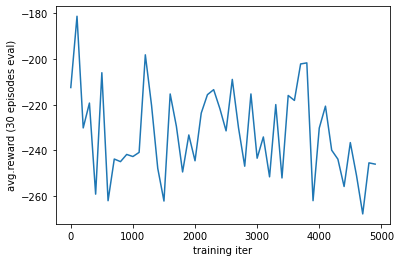

In [39]:
x = np.arange(0, training_iters, args.save_freq)
y = evaluations
plt.plot(x, y)
plt.ylabel('avg.reward (30 episodes eval)')
plt.xlabel('training iter')

## Evaluate

In [40]:
import os
import imageio
import numpy as np
from PIL import Image
import PIL.ImageDraw as ImageDraw
import matplotlib.pyplot as plt    

def _label_with_episode_number(frame, episode_num):
    im = Image.fromarray(frame)

    drawer = ImageDraw.Draw(im)

    if np.mean(im) < 128:
        text_color = (255,255,255)
    else:
        text_color = (0,0,0)
    drawer.text((im.size[0]/20,im.size[1]/18), f'Episode: {episode_num+1}', fill=text_color)

    return im


def save_agent_gif(env, random=False, fname='agent.gif', n_iter = 5):
    frames = []
    for i in range(n_iter):
        state = env.reset()        
        for t in range(500):
            
            if random:
                action = env.action_space.sample()
            else:
                action = best_policy.select_action(state)

            frame = env.render(mode='rgb_array')
            frames.append(_label_with_episode_number(frame, episode_num=i))

            state, _, done, _ = env.step(action)
            if done:
                break

    env.close()
    imageio.mimwrite(os.path.join(folder_name, fname), frames, fps=30)

## Results Dictionary

In [51]:
results_ = dict(
    env_type = [],
    agent_type = [],
    avg_reward = []
)

## Define Env - same parameters used to generate data

In [50]:
env = gym.make(
    env_name,
    continuous = True,
    gravity = -10.0,
    enable_wind = True,
    wind_power = 5, # between 0 and 20
    turbulence_power = 1, # between 0 and 2
)

### Random Agent

In [53]:
#Eval
env.reset()
# evaluations = []
info = eval_policy(best_policy, env, eval_episodes=30, random=True)

results_['env_type'] += ['baseline']
results_['agent_type'] += ['random']
results_['avg_reward'] += [info['AverageReturn']]

# evaluations.append(info['AverageReturn'])

---------------------------------------
Evaluation over 30 episodes: -206.931
---------------------------------------


In [54]:
env.reset()
save_agent_gif(env, random=True, fname='random.gif', n_iter=5)

### Trained agent

In [55]:
#Eval
env.reset()
# evaluations = []
info = eval_policy(best_policy, env, eval_episodes=30)

results_['env_type'] += ['baseline']
results_['agent_type'] += ['plas']
results_['avg_reward'] += [info['AverageReturn']]

# evaluations.append(info['AverageReturn'])
# np.save(os.path.join(folder_name, 'eval'), evaluations)

---------------------------------------
Evaluation over 30 episodes: -225.797
---------------------------------------


In [56]:
env.reset()
save_agent_gif(env, fname='agent1.gif', n_iter=5)

In [58]:
pd.DataFrame(results_)

,env_type,agent_type,avg_reward
0,baseline,random,-206.930662
1,baseline,plas,-225.796625


## Define Env - Tweaked parameters

In [ ]:
# change environment parameters